# Analysis for Climate Discourse paper

This notebook contains the analysis for the 'substantive' paper

In [104]:
import pandas as pd

import numpy as np
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


# Dataset overview and datawrangling

In [105]:
df = pd.read_csv('../data/annotations/twitter_klimaat_discussie_coderingen.csv')

In [9]:
## number of unique annotators:

In [52]:
len(df['coder_id'].unique())

1517

<Axes: >

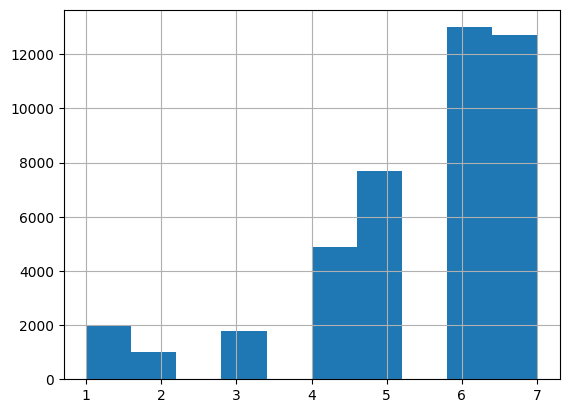

In [14]:
df['scientific_consensus.pro_klimaat'].hist()

In [57]:
df['comment_inhoudelijk_argument'].value_counts()
#df.info()

comment_inhoudelijk_argument
Inhoudelijk argument         21588
Geen inhoudelijk argument    21556
Neutraal                        15
Ja                              15
Nee                              7
Name: count, dtype: int64

# FOR NOW: 

## Remove Neutral/ Ja / Nee --> NOT SURE WHAT TO DO WITH THIS

In [106]:
values_to_drop = ['Neutraal', 'Ja', 'Nee']
df = df[~df['comment_inhoudelijk_argument'].isin(values_to_drop)]
df['comment_inhoudelijk_argument'].value_counts()

comment_inhoudelijk_argument
Inhoudelijk argument         21588
Geen inhoudelijk argument    21556
Name: count, dtype: int64

## Remove missing obs

In [107]:
print(len(df))
df = df.dropna(subset=['scientific_consensus.pro_klimaat'])
df = df.dropna(subset=['age'])
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['comment_respectvol'])
print(len(df))

43145
42744


In [108]:
len(df['coder_id'].unique())

1504

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42744 entries, 0 to 43181
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   coder_id                                   42744 non-null  int64  
 1   jobset                                     42744 non-null  object 
 2   scientific_consensus.pro_klimaat           42744 non-null  float64
 3   scientific_consensus.belangrijk_onderwerp  42744 non-null  float64
 4   scientific_consensus.sterke_mening         42744 non-null  float64
 5   scientific_consensus.interesse_klimaat     42744 non-null  float64
 6   age                                        42744 non-null  float64
 7   gender                                     42744 non-null  object 
 8   education                                  42744 non-null  object 
 9   workhours                                  42744 non-null  object 
 10  tweet_id                   

## Internal consistency of the *issue importance* scale

In [109]:
# Specify the columns for which you want to calculate Cronbach's alpha
selected_columns = ['scientific_consensus.belangrijk_onderwerp',
                    'scientific_consensus.sterke_mening',
                    'scientific_consensus.interesse_klimaat']

# Group by 'coder_id' and calculate Cronbach's alpha for selected columns
grouped_data = df.groupby('coder_id')[selected_columns].first()

# Calculate Cronbach's alpha for the selected columns
alpha_result = pg.cronbach_alpha(grouped_data)
alpha_result

(0.8076223379196215, array([0.79 , 0.824]))

In [110]:
# Create a new column 'average_score' that contains the average of the specified columns
df['scale_importance'] = df[selected_columns].mean(axis=1)
# Display the result

In [111]:
#df[df['tweet_pro_klimaat'] == 'Eens']
df['comment_pro_klimaat'].value_counts()

comment_pro_klimaat
Nee         15229
Ja          15011
Neutraal    12504
Name: count, dtype: int64

In [112]:
df['gender'].value_counts()

gender
Vrouw                        22345
Man                          20105
Non-binary                     184
Wil ik liever niet zeggen      110
Name: count, dtype: int64

In [113]:
df['comment_respectvol'].value_counts()

comment_respectvol
Eens      29334
Oneens    13410
Name: count, dtype: int64

## recoding variables

In [114]:
# Create two dummy variables for 'comment_pro_klimaat'
dummy_variables = pd.get_dummies(df['comment_pro_klimaat'], prefix='comment_pro_klimaat')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

df[['coder_id', 'comment_pro_klimaat', 'comment_pro_klimaat_Ja', 'comment_pro_klimaat_Nee']]. head(6)

,coder_id,comment_pro_klimaat,comment_pro_klimaat_Ja,comment_pro_klimaat_Nee
0,11,Ja,1,0
1,11,Ja,1,0
2,11,Ja,1,0
3,11,Neutraal,0,0
4,11,Neutraal,0,0
5,11,Neutraal,0,0


In [115]:
df['tweet_pro_klimaat'].value_counts()

recode_mapping = {'Eens': 'Ja', 'Oneens': 'Nee'}

# Recode 'tweet_pro_klimaat'
df['tweet_pro_klimaat'] = df['tweet_pro_klimaat'].replace(recode_mapping)

dummy_variables = pd.get_dummies(df['tweet_pro_klimaat'], prefix='tweet_pro_klimaat')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [116]:
# Create two dummy variables for 'comment_pro_klimaat'
dummy_variables = pd.get_dummies(df['comment_respectvol'], prefix='comment_respectvol')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [117]:
df['coder_id'] = df['coder_id'].astype(str)

In [118]:
# Mapping of categories to two groups
gender_mapping = {
    'Vrouw': 'Female',
    'Man': 'Male',
    'Non-binary': 'Other',
    'Wil ik liever niet zeggen': 'Other'
}

df['recoded_gender'] = df['gender'].map(gender_mapping)

df['male_dummy'] = (df['recoded_gender'] == 'Male').astype(int)
df['female_dummy'] = (df['recoded_gender'] == 'Female').astype(int)

In [119]:
df['comment_inhoudelijk_argument_Ja'] = (df['comment_inhoudelijk_argument'] == 'Inhoudelijk argument').astype(int)

In [120]:
education_mapping = {
    'Voorbereidend of kort middelbaar beroepsonderwijs (VMBO, KMBO)': 'Lager',
    'Hoger beroepsonderwijs (HBO, HTS, HEAO, Sociale Academie, HHNO, lerarenonderwijs, etc.': 'Hoger',
    'Middelbaar beroepsonderwijs (MBO, MTS, MEAO, Praktijkdiploma Boekhouden, Kleuterkweekschool, etc.': 'Lager',
    'Anders': 'Lager',
    'Wetenschappelijk onderwijs (universiteit)': 'Hoger',
    'Voortgezet algemeen onderwijs (5-jaar HBS, MMS, HAVO, Lyceum, Atheneum, Gymnasium, VWO, etc.': 'Lager',
    'Lager beroepsonderwijs (LBO, LTS, LHNO, huishoud-/ambachts-school, LEAO, lage land-en tuinbouwonderwijs etc.)': 'Lager',
    'Middelbaar algemeen onderwijs (LAVO, ULO, MULO, MAVO, 3-jaar HBS, etc)': 'Lager',
    'Lagere school (basisonderwijs)': 'Lager',
    'Geen onderwijs of niet afgemaakt': 'Lager'
}

# Recode 'education' into a new column 'recoded_education'
df['recoded_education'] = df['education'].map(education_mapping)
df['recoded_education_hoger'] = (df['recoded_gender'] == 'Hoger').astype(int)

In [121]:
df[['tweet_id', 'jobset', 'comment_nr']].head(10)

,tweet_id,jobset,comment_nr
0,22,set_3,1
1,22,set_3,2
2,22,set_3,3
3,22,set_3,4
4,22,set_3,5
5,24,set_3,1
6,24,set_3,2
7,24,set_3,3
8,24,set_3,4
9,24,set_3,5


In [122]:
df['scientific_consensus_pro_klimaat'] = df['scientific_consensus.pro_klimaat']

## RUnning some models

In [123]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit a logistic mixed-effects regression model
formula = 'comment_pro_klimaat_Nee ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat + comment_respectvol_Eens + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge

                   Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   comment_pro_klimaat_Nee
No. Observations:    42744     Method:               REML                   
No. Groups:          1504      Scale:                0.1639                 
Min. group size:     15        Log-Likelihood:       -24708.8286            
Max. group size:     34        Converged:            No                     
Mean group size:     28.4                                                   
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.493    0.061   8.144 0.000  0.374  0.612
recoded_education[T.Lager]       -0.063    0.023  -2.729 0.006 -0.108 -0.018
age                               0.002    0.001   2.660 0.008  0.000  0.003
male_dummy         

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [124]:
# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat * comment_pro_klimaat_Nee + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                               Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           comment_respectvol_Eens
No. Observations:           42744             Method:                       REML                   
No. Groups:                 1504              Scale:                        0.1762                 
Min. group size:            15                Log-Likelihood:               -25409.7395            
Max. group size:            34                Converged:                    Yes                    
Mean group size:            28.4                                                                   
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

In [125]:
df[['comment_pro_klimaat_Ja', 'comment_pro_klimaat']]

,comment_pro_klimaat_Ja,comment_pro_klimaat
0,1,Ja
1,1,Ja
2,1,Ja
3,0,Neutraal
4,0,Neutraal
...,...,...
43177,0,Nee
43178,0,Nee
43179,0,Nee
43180,0,Nee


In [126]:
# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ scientific_consensus_pro_klimaat * comment_pro_klimaat_Ja'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          comment_respectvol_Eens
No. Observations:            42744            Method:                      REML                   
No. Groups:                  1504             Scale:                       0.1791                 
Min. group size:             15               Log-Likelihood:              -25271.9987            
Max. group size:             34               Converged:                   Yes                    
Mean group size:             28.4                                                                 
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/tmp/ipykernel_93233/2289508864.py:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(x='scientific_consensus_pro_klimaat', y=predicted_probs, hue='comment_pro_klimaat_Ja', data=interaction_data,


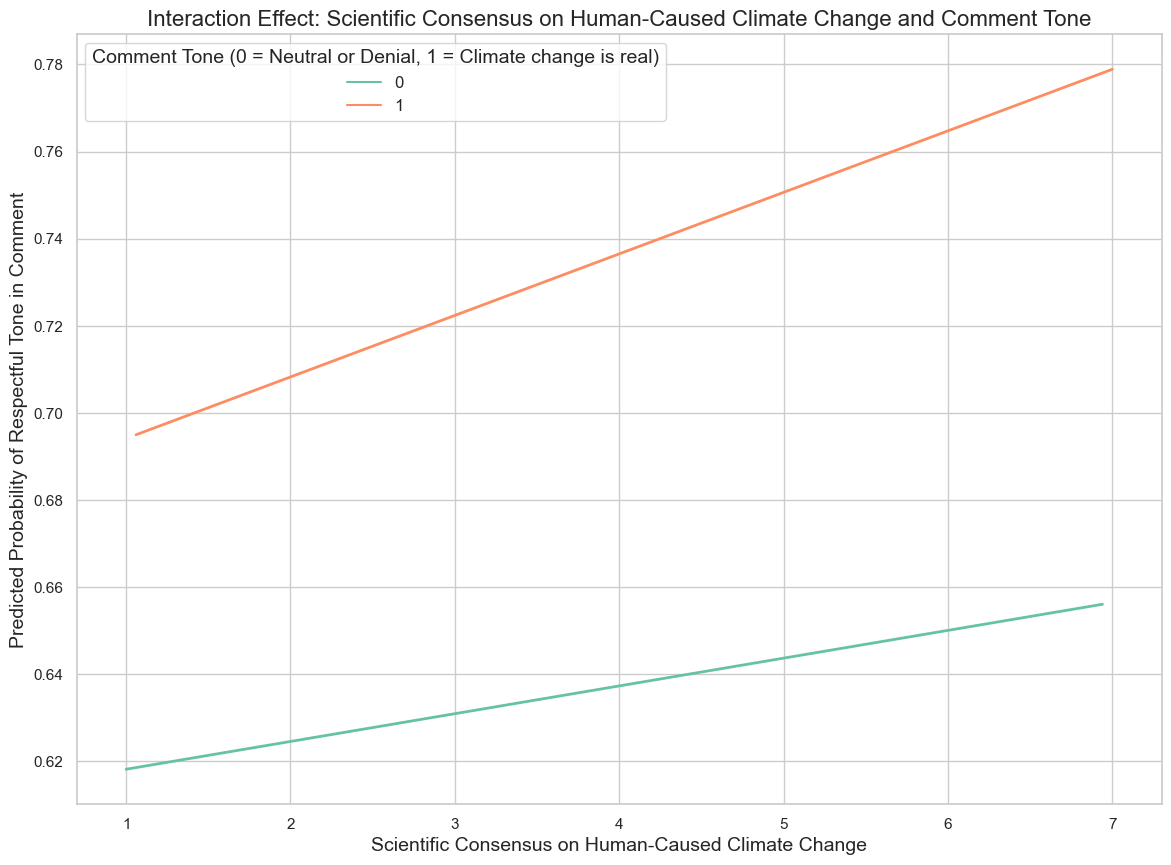

In [129]:
interaction_data = pd.DataFrame({
    'scientific_consensus_pro_klimaat': np.linspace(df['scientific_consensus_pro_klimaat'].min(),
                                                    df['scientific_consensus_pro_klimaat'].max(), 100),
    'comment_pro_klimaat_Ja': [0, 1] * 50,  # Two levels for interaction
})

predicted_probs = result.predict(interaction_data)

sns.set(style='whitegrid')

# Create a more visually appealing interaction plot
plt.figure(figsize=(14, 10))
sns.lineplot(x='scientific_consensus_pro_klimaat', y=predicted_probs, hue='comment_pro_klimaat_Ja', data=interaction_data,
             palette=sns.color_palette('Set2'), linewidth=2)

# Set plot title and labels
plt.title('Interaction Effect: Scientific Consensus on Human-Caused Climate Change and Comment Tone', fontsize=16)
plt.xlabel('Scientific Consensus on Human-Caused Climate Change', fontsize=14)
plt.ylabel('Predicted Probability of Respectful Tone in Comment', fontsize=14)

# Customize legend
plt.legend(title='Comment Tone (0 = Neutral or Denial, 1 = Climate change is real)', fontsize=12, title_fontsize=14)

# Display the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'result' is your fitted model result
# Replace this with your actual result

# Generate data for interaction plot
interaction_data = pd.DataFrame({'scientific_consensus_pro_klimaat': np.linspace(df['scientific_consensus_pro_klimaat'].min(),
                                                                               df['scientific_consensus_pro_klimaat'].max(), 100),
                                 'comment_pro_klimaat_Nee': [0, 1] * 50,  # Two levels for interaction
                                 'male_dummy': df['male_dummy'].mean(),  # Mean value for other variables
                                 'recoded_education': df['recoded_education'].mean(),
                                 'scale_importance': df['scale_importance'].mean(),
                                 'age': df['age'].mean(),
                                 'comment_nr': df['comment_nr'].mean()})

# Predict probabilities for each level of the interacting variables
predicted_probs = result.predict(interaction_data)

# Create interaction plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='scientific_consensus_pro_klimaat', y=predicted_probs, hue='comment_pro_klimaat_Nee', data=interaction_data)
plt.title('Interaction Effect: scientific_consensus_pro_klimaat * comment_pro_klimaat_Nee')
plt.xlabel('scientific_consensus_pro_klimaat')
plt.ylabel('Predicted Probability of comment_respectvol_Eens')
plt.legend(title='comment_pro_klimaat_Nee')
plt.show()


In [131]:

formula = 'comment_inhoudelijk_argument_Ja  ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat + comment_respectvol_Eens + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: comment_inhoudelijk_argument_Ja
No. Observations: 42744   Method:             REML                           
No. Groups:       1504    Scale:              0.2026                         
Min. group size:  15      Log-Likelihood:     -27878.3116                    
Max. group size:  34      Converged:          Yes                            
Mean group size:  28.4                                                       
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.271    0.030  9.134 0.000  0.213  0.329
recoded_education[T.Lager]          0.083    0.011  7.622 0.000  0.062  0.104
age                                -0.000    0.000 -0.299 0.765 -0.001  0.001
male_d

In [138]:

formula = 'tweet_pro_klimaat_Nee ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   tweet_pro_klimaat_Nee
No. Observations:     42844     Method:               REML                 
No. Groups:           1505      Scale:                0.1289               
Min. group size:      15        Log-Likelihood:       -19057.9578          
Max. group size:      34        Converged:            Yes                  
Mean group size:      28.5                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.287    0.039  7.440 0.000  0.212  0.363
recoded_education[T.Lager]       -0.051    0.014 -3.496 0.000 -0.079 -0.022
age                               0.003    0.000  6.258 0.000  0.002  0.003
male_dummy                     

In [129]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat'
model = smf.mixedlm(formula, df, groups=df['coder_id'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/anne/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   comment_respectvol_Eens
No. Observations:   42844     Method:               REML                   
No. Groups:         1505      Scale:                0.1813                 
Min. group size:    15        Log-Likelihood:       -25625.4174            
Max. group size:    34        Converged:            Yes                    
Mean group size:    28.5                                                   
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.625    0.029 21.693 0.000  0.568  0.681
recoded_education[T.Lager]       -0.027    0.011 -2.460 0.014 -0.048 -0.005
age                              -0.000    0.000 -0.026 0.979 -0.001  0.001
male_dummy                     